In [1]:
%load_ext autoreload
%autoreload 2

# Loading Classes For Model and Dataset

In [2]:
%run Model.ipynb

In [3]:
%run NimbroDataLoader-RGB.ipynb

In [4]:
%run NimbroSegmentDataLoader.ipynb

In [5]:
%run NimbroDataLoader-RGB-YAML.ipynb

In [6]:
seed = 7
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic=True

# Loading Blob Dataset

In [7]:
dataset1 = NimbroDataset('data/bigcuda5.informatik.uni-bonn.de:8686/blob/forceTest/',image_size=(HEIGHT,WIDTH))

dataset2 = NimbroDataset('data/bigcuda5.informatik.uni-bonn.de:8686/blob/forceTrain/',image_size=(HEIGHT,WIDTH))

dataset3 = NimbroDataset('data/bigcuda5.informatik.uni-bonn.de:8686/blob/dataset/',image_size=(HEIGHT,WIDTH))

In [8]:
batch_size = 32

In [9]:
blob_dataset = ConcatDataset([dataset1,dataset2,dataset3])

## Splitting Blob Dataset

In [10]:
train_blob_len = int(len(blob_dataset)*0.8)
val_blob_len = int(len(blob_dataset)*0.1)

train_blob, val_blob, test_blob = torch.utils.data.random_split(blob_dataset, [train_blob_len,val_blob_len,len(blob_dataset)-train_blob_len-val_blob_len])

print(f'Train Dataset Size:{len(train_blob)}. Validation Size:{len(val_blob)}. Test Size:{len(test_blob)}')

Train Dataset Size:7094. Validation Size:886. Test Size:888


## Sample Dataset from Blobs

In [12]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

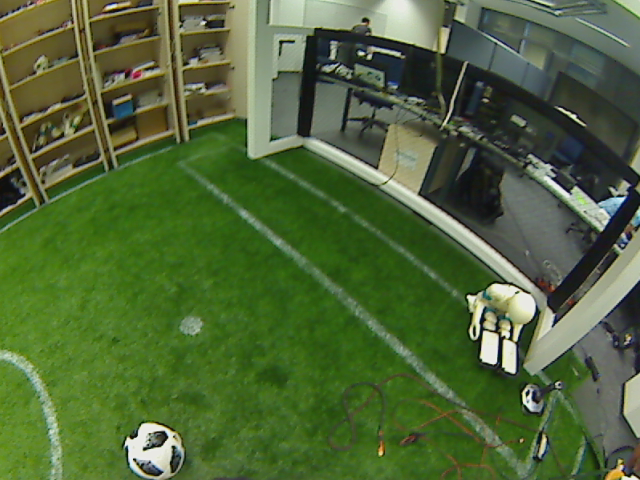

In [13]:
TF.to_pil_image(invTrans(train_blob[50][0]))

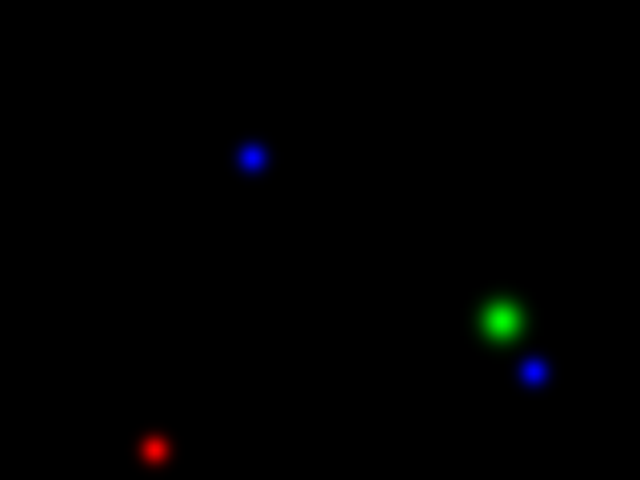

In [14]:
TF.resize(TF.to_pil_image(train_blob[50][1]),(480,640))

## Batching and loading blob dataset

In [15]:
train_blob_loader = torch.utils.data.DataLoader(dataset=blob_dataset, 
                               batch_size=batch_size, 
                               shuffle=True)
val_blob_loader = torch.utils.data.DataLoader(dataset=val_blob, 
                               batch_size=batch_size, 
                               shuffle=False)
test_blob_loader = torch.utils.data.DataLoader(dataset=test_blob, 
                               batch_size=batch_size, 
                               shuffle=False)

# Loading Segmentation Dataset

In [16]:
dataset_seg_1 = NimbroSegmentDataset('data/bigcuda5.informatik.uni-bonn.de:8686/segmentation/forceTrain/',(HEIGHT,WIDTH))
dataset_seg_2 = NimbroSegmentDataset('data/bigcuda5.informatik.uni-bonn.de:8686/segmentation/dataset/',(HEIGHT,WIDTH))

dataset_seg = ConcatDataset([dataset_seg_1,dataset_seg_2])
len(dataset_seg)

1192

## Sample from Segmentation

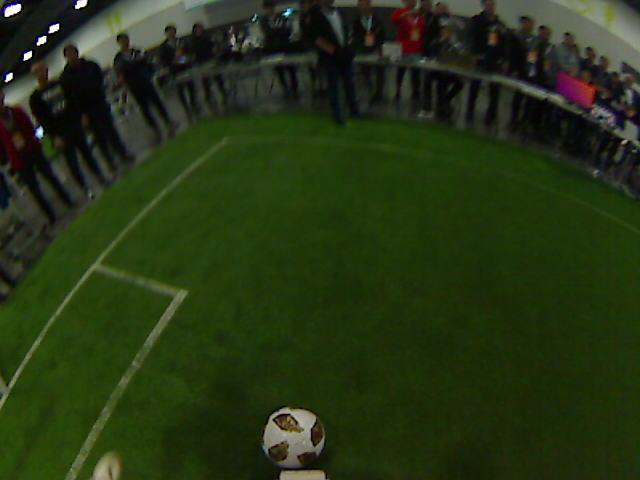

In [17]:
TF.to_pil_image(invTrans(dataset_seg_1[50][0]))

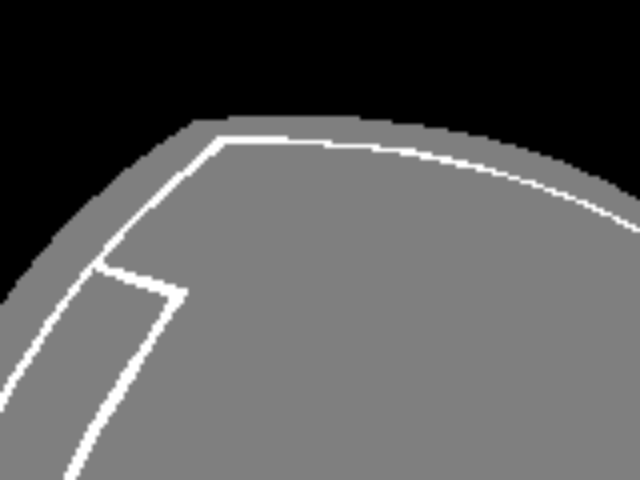

In [18]:
TF.resize(TF.to_pil_image(dataset_seg_1[50][1]/2),(480,640))

## Batching and loading segmentation dataset

In [19]:
train_seg_len = int(len(dataset_seg)*0.8)
val_seg_len = int(len(dataset_seg)*0.1)
train_seg_dataset,val_seg_dataset,test_seg_dataset = torch.utils.data.random_split(dataset_seg,
                                                                                   [train_seg_len,
                                                                                    val_seg_len,
                                                                                    len(dataset_seg)-train_seg_len-val_seg_len])

print(f'Train Dataset Size:{len(train_seg_dataset)}. Validation Size:{len(val_seg_dataset)}. Test Size:{len(test_seg_dataset)}')

Train Dataset Size:953. Validation Size:119. Test Size:120


In [20]:
val_seg_loader = torch.utils.data.DataLoader(dataset=val_seg_dataset, 
                               batch_size=batch_size, 
                               shuffle=False)
train_seg_loader = torch.utils.data.DataLoader(dataset=train_seg_dataset, 
                               batch_size=batch_size, 
                               shuffle=True)

# Optimiser and Network objects

In [21]:
n_epochs = 300
n_batchs = 50
lr = 0.001
nimbro_net = NimbroNet18()
optimizer = torch.optim.Adam(nimbro_net.parameters(), lr=lr, betas=(0.8, 0.999))

In [22]:
nimbro_net.cuda()

NimbroNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=Tru

# Loss function for training

In [23]:
criterion_cross_ent = nn.CrossEntropyLoss()

def mse_loss_fn(y_hat,y):
    return ((y - y_hat)**2).sum()/y.shape[0]

def total_variation_loss(y):
    return (torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) + torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])))/y.shape[0]

# Evaluation Metric for Detection Head

In [57]:
from torchvision.utils import make_grid

def get_metric(loader,writeTensorFlow=False, epoch=0,save_images=False,mode='Validation'):
    '''
    method for printing, saving losses on Tensorboard. It can be used to save images as well
    
    '''
    nimbro_net.eval()
    
    # initial values of False Positive, True Positive, False Negative and True Negative
    fp = [0,0,0]
    tp = [0,0,0]
    fn = [0,0,0]
    tn = [0,0,0]
    
    # Tolerance of error for Ball, Robot and Goal Post respectively 
    pixel_dist = [6,12,8]
    
    # Threshhold used in calculating centers of the detections
    threshhold = [0.8,0.9,0.88]
    
    # for generating samples
    imgs_fn=[[],[],[]]
    imgs_fp=[[],[],[]]
    SAMPLES = 20
    IMAGE_PER_SAMPLE=27
    imgs_true=[]
    
    for image,target in loader:
        seg,blob = nimbro_net(image.unsqueeze(0).cuda())
        
        sum_false = sum(fp) + sum(fn)
        
        # for generating output from predicted annotations
        pred_annotations = {'goalpost':[],'ball':[],'robot':[]}
        
        for label,channel in dataset1.object_to_channel.items():
            old_fn = fn[channel]
            old_fp = fp[channel]
            
            # converting torch image to cv2 8 bit image and finding centeroids from target
            img = target.numpy().copy()[channel]
            img *= 255
            img = img.astype(np.uint8)
            true_centroids = find_contours(img)
            
            # converting torch image to cv2 8 bit image and finding centeroids from predicted blob 
            img = blob[0,channel].cpu()
            img = blob.cpu()[0,channel]-threshhold[channel] # threshholding the image
            img *= 255
            img = img.type(torch.uint8)
            img = img.detach().numpy()
            pred_centroids = find_contours(img)
            
            # saving the predicited labels
            pred_annotations[label] = pred_centroids
            
            # predictions and true labels are both absent
            if len(pred_centroids) == len(true_centroids) and len(pred_centroids) == 0:
                tn[channel] += 1
            
            # assuming every prediction as false positive (decreased later upon correct matching)
            fp[channel] += len(pred_centroids)
            
            for t_ct in true_centroids:
                found = False
                for p_ct in pred_centroids:
                    
                    # prediction and true label are within tolerance
                    if abs(t_ct[0]-p_ct[0]) <= pixel_dist[channel] and abs(t_ct[1]-p_ct[1]) <=pixel_dist[channel]:
                        
                        # increasing count of true positive and decreasing count of false positive
                        tp[channel] += 1
                        fp[channel] -= 1
                        found = True
                        break
               
                if not found:
                    fn[channel] += 1
        
            # for saving false negatives and false positives
            if save_images:
                if fn[channel] > old_fn :
                    # target added to original image
                    imgs_fn[channel].append(invTrans(image)+ TF.to_tensor(TF.resize(TF.to_pil_image(target),(HEIGHT,WIDTH))))
                    
                    # predition added to original image
                    imgs_fn[channel].append(TF.to_tensor(TF.resize(TF.to_pil_image(blob[0].cpu().detach() - 0.7),(HEIGHT,WIDTH))))

                if fp[channel] > old_fp:
                    # target added to original image
                    imgs_fp[channel].append(invTrans(image)+ TF.to_tensor(TF.resize(TF.to_pil_image(target),(HEIGHT,WIDTH))))
                    
                    # predition added to original image
                    imgs_fp[channel].append(TF.to_tensor(TF.resize(TF.to_pil_image(blob[0].cpu().detach() - 0.7),(HEIGHT,WIDTH))))
        
        # for saving true positive and true negatives
        seg_op = seg.detach().cpu().squeeze(0).argmax(0)/2.0
        seg_op.unsqueeze_(0)
        seg_op = seg_op.repeat(3, 1, 1)
        if save_images and sum(fp) + sum(fn) == sum_false and len(imgs_true) < IMAGE_PER_SAMPLE*SAMPLES:
            imgs_true.extend([TF.to_tensor(TF.resize(TF.to_pil_image(invTrans(image)),(HEIGHT//4,WIDTH//4))),
                              dataset1.annotation_to_target(pred_annotations,HEIGHT//4,WIDTH//4),
                              seg_op])
            
    # writing True predicitions on Tensorboard
    if save_images:
        for s in range(SAMPLES):
            img_grid = make_grid(imgs_true[s*IMAGE_PER_SAMPLE:(s+1)*IMAGE_PER_SAMPLE],nrow=9)
            writer.add_image(f'Sample {s}',img_grid)
    
    
    for channel,label in channel_to_label.items():
    
        recall = tp[channel]/(tp[channel] + fn[channel])  # Recall
        print(f'{label}    \tRecall:{recall:.3f}')
        
        precision = tp[channel]/(tp[channel] + fp[channel]) # Precision
        print(f'\t\tPrecision:{precision:.3f}')
        
        accuracy = (tp[channel] + tn[channel])/(tp[channel] + fp[channel] + tn[channel] + fn[channel]) # Accuracy
        print(f'\t\tAccuracy: {accuracy:.3f}')
        
        print(f'\t\tF1 Score:{2*precision*recall/(precision+recall):.3f}') # F1 score
        
        print(f'\t\tFDR:{1-precision:.3f}')   # False Detection Rate
        
        # Writing on TensorBoard
        if writeTensorFlow:
            writer.add_scalar(f'{mode} {label} Recall', recall,epoch)
            writer.add_scalar(f'{mode} {label} Precision', precision,epoch)
            writer.add_scalar(f'{mode} {label} Accuracy', accuracy,epoch)
        
    
        if save_images:
            img_grid = make_grid(imgs_fn[channel])
            writer.add_image(f'{mode} Failed {label} FN',img_grid)
            img_grid = make_grid(imgs_fp[channel])
            writer.add_image(f'{mode} Failed {label} FP',img_grid)


        print('------------------------------------------')
    
    print('-----------------------------------------\n')
    


# Evaluation metric for Segmentation Head

In [25]:
def get_seg_metric(loader,writeTensorFlow=False, epoch=0,mode='Validation'):
    
    nimbro_net.eval()
    # initialising counts for true count, correct count and predicted count respectively
    class_accuracy = {'Background':[0,0,0],'Field':[0,0,0],'Line':[0,0,0]}

    for k,(images, target) in enumerate(loader):

        images = images.cuda()

        seg,_ = nimbro_net(images)
        seg_classes = seg.cpu().argmax(1)
        
        for label,class_ in enumerate(class_accuracy):
            class_accuracy[class_][0] += (target == label).sum().item()  # True Count
            class_accuracy[class_][1] += ((target == label) & (seg_classes == label) ) .sum().item() # Correct Count
            class_accuracy[class_][2] += (seg_classes == label).sum().item() # Predicted Count
    
    # For average calculation
    iou_sum = 0
    accuracy_sum = 0
    
    for label,val in class_accuracy.items():
        if writeTensorFlow:
            writer.add_scalar(f'{mode} {label} Accuracy', val[1]/val[0],epoch)
            writer.add_scalar(f'{mode} {label} IOU', val[1]/(val[0]+val[2]-val[1]),epoch)
        print(f'{label}    \tAccuracy:{val[1]/val[0]:.3f},   \tIoU:{val[1]/(val[0]+val[2]-val[1]):.3f}')
        accuracy_sum += val[1]/val[0]
        iou_sum += val[1]/(val[0]+val[2]-val[1])
    print(f'Average Accuracy {accuracy_sum/3:.3f}, Average IoU:{iou_sum/3:.3f}')

# Helper Functions for Detection Metric

In [26]:
channel_to_label={0:'Ball', 2:'Goal Post', 1:'Robot'}

In [27]:
def dist2(p1, p2):
    return (p1[0]-p2[0])**2 + (p1[1]-p2[1])**2

def fuse(points, d=20):
    '''method to fuse nearby centroid points'''
    ret = []
    d2 = d * d
    n = len(points)
    taken = [False] * n
    for i in range(n):
        if not taken[i]:
            count = 1
            point = [points[i][0], points[i][1]]
            taken[i] = True
            for j in range(i+1, n):
                if dist2(points[i], points[j]) < d2:
                    point[0] += points[j][0]
                    point[1] += points[j][1]
                    count+=1
                    taken[j] = True
            point[0] /= count
            point[1] /= count
            ret.append((point[0], point[1]))
    return ret

In [28]:
import cv2
import numpy
import scipy.misc
import PIL.Image
from matplotlib import pyplot as plt
import IPython
    
def find_contours(img):
    '''method for calculating contours and finally centroids from detection images'''
    points = []
    ret,thresh = cv2.threshold(img,127,255, cv2.THRESH_BINARY)
    contours,hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for i in range(len(contours)):
        cnt = contours[i]
        M = cv2.moments(cnt)
        if M['m00'] == 0: 
            continue
        centroid_x = int(M['m10']/M['m00'])
        centroid_y = int(M['m01']/M['m00'])
        points.append((centroid_y,centroid_x))
    
    
    return fuse(points)

# Training Loop

In [29]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs_final/nimbro_experiment_4')

In [30]:
train_losses = []
val_losses = []
iter_ = 0

In [ ]:
nimbro_net.train()
var_loss_blob_weight = 0.000002
var_loss_seg_weight = 0.00003
mse_loss_weight = 0.03


for epoch in range(n_epochs):
    for batch_id in range(n_batchs):
        
        ######### training on blobs ########
        images, target = next(iter(train_blob_loader))
        
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = images.cuda()
            target = target.cuda()
        
        
        optimizer.zero_grad()
        
        _,blob = nimbro_net(images)

        # calculating total variance loss and MSE Loss
        ttl_var_blob = total_variation_loss(blob)*var_loss_blob_weight
        mse_loss = mse_loss_fn(blob, target)*mse_loss_weight
        blob_loss = ttl_var_blob + mse_loss
        
        #backprop
        blob_loss.backward()
        optimizer.step()
        
        # writing on tensorboard
        writer.add_scalar('Train MSE', mse_loss.item(),global_step=iter_)
        writer.add_scalar('Train Variance Loss(Blobs)',ttl_var_blob.item(),iter_)
        
        ####### training on segmentation ######
        images, target_seg = next(iter(train_seg_loader))  
        if torch.cuda.is_available():
            images = images.cuda()
            target_seg = target_seg.cuda()
            
        optimizer.zero_grad()
        seg,_ = nimbro_net(images)
        
        # Cross Entropy and Total variance loss
        ttl_var_seg = total_variation_loss(seg[:,[0,1],:,:])*var_loss_seg_weight
        cross_loss = criterion_cross_ent(seg,target_seg.long())
        seg_loss = cross_loss + ttl_var_seg
        
        # backprop
        seg_loss.backward()
        optimizer.step()
    
        train_losses.append((mse_loss.item(),ttl_var_blob.item(),cross_loss.item(),ttl_var_seg.item()))
        writer.add_scalar('Train Cross Entropy',cross_loss.item(),iter_)
        writer.add_scalar('Train Variance Loss(Segmentation)',ttl_var_seg.item(),iter_)
        iter_ += 1
        writer.flush()
        
    print(f'Epoch:{epoch} Train MSE: {mse_loss.item():.3f}\t\tCross Entropy: {cross_loss.item():.3f}')
    print(f'\tVariance Loss Blobs:{ttl_var_blob.item():.2}\tVariance Loss Seg:{ttl_var_seg.item():.3}')

    ## Validation Accuracy and losses
    nimbro_net.eval()
    with torch.no_grad():
        mse_loss = 0
        seg_loss = 0
        tot_var_loss_blob = 0
        tot_var_loss_seg = 0

        for k,(images, target) in enumerate(val_blob_loader):
            #######################
            #  USE GPU FOR MODEL  #
            #######################
            if torch.cuda.is_available():
                images = images.cuda()
                target = target.cuda()

            # Forward pass only to get logits/output
            _,blob = nimbro_net(images)
            mse_loss +=   (mse_loss_fn(blob,target).item()-mse_loss)/(k+1)
            tot_var_loss_blob += (total_variation_loss(blob) - tot_var_loss_blob)/(k+1)

        for k,(images, target) in enumerate(val_seg_loader):
            #######################
            #  USE GPU FOR MODEL  #
            #######################
            if torch.cuda.is_available():
                images = images.cuda()
                target = target.cuda()

            # Forward pass only to get logits/output
            seg,_ = nimbro_net(images)
            seg_loss +=   (criterion_cross_ent(seg,target.long()).item()-seg_loss)/(k+1)
            tot_var_loss_seg += (total_variation_loss(seg[:,[0,1],:,:]) - tot_var_loss_seg)/(k+1)
    

    # Print Loss
    tot_var_loss_blob *= var_loss_blob_weight
    tot_var_loss_seg  *= var_loss_seg_weight
    mse_loss *= mse_loss_weight
    
    writer.add_scalar('Validation MSE', mse_loss,epoch)
    writer.add_scalar('Validation Cross Entropy',seg_loss,epoch)
    writer.add_scalar('Validation Variance Loss(Blobs)',tot_var_loss_blob.item(),epoch)
    writer.add_scalar('Validation Variance Loss(Segmentation)',tot_var_loss_seg.item(),epoch)
    print(f'\tValidation MSE Loss: {mse_loss:.3f}\tCross Entropy: {seg_loss:.3f}')
    print(f'\tVariance Loss Blobs:{tot_var_loss_blob:.3}\tVariance Loss Seg:{tot_var_loss_seg:.2}\n--------------------------------------------------------------\n')
    
    get_metric(val_blob,True,epoch)
    get_seg_metric(val_seg_loader,True,epoch)
    writer.flush()
    
    val_losses.append((mse_loss,tot_var_loss_blob.item(),seg_loss,tot_var_loss_seg.item()))
    nimbro_net.train()

In [53]:
torch.save(nimbro_net.state_dict(),'./6thApril-300epoch-2.pt')

# Sample Result from Segmentation Test Set

In [34]:
nimbro_net.eval()
i=900
ds = train_seg_dataset

## Input Image (un-normailised)

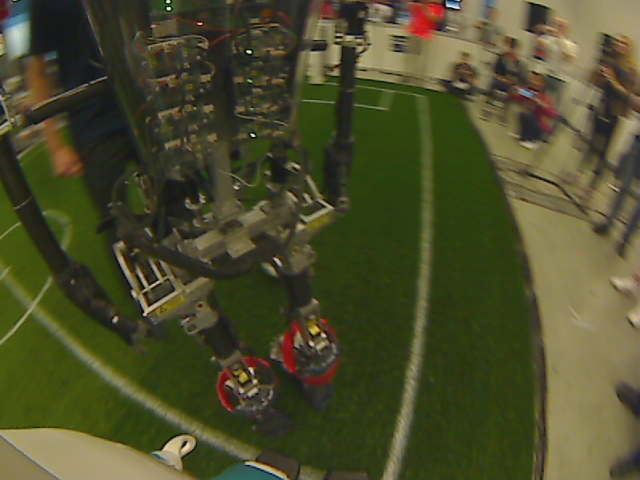

In [35]:
TF.to_pil_image(invTrans(ds[i][0]))

## Expected Segmentation output

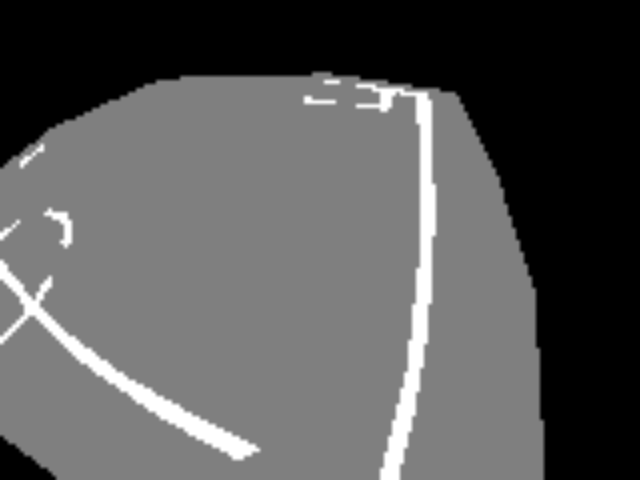

In [36]:
nimbro_net.eval()
TF.resize(TF.to_pil_image(ds[i][1]/2),(480,640))

## Output Produced

In [37]:
seg,blob = nimbro_net(ds[i][0].unsqueeze(0).cuda())

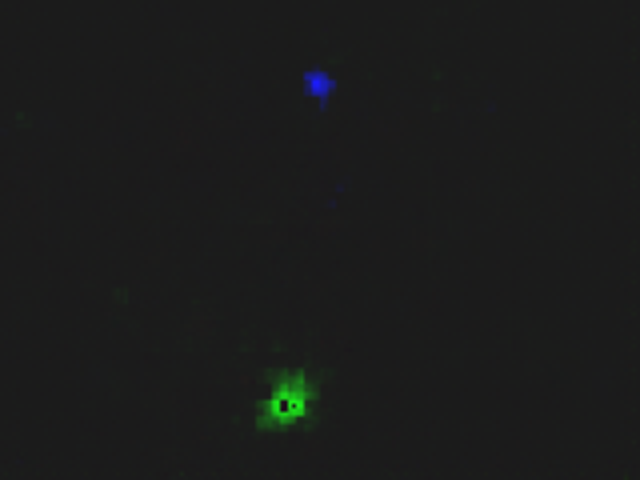

In [51]:
TF.resize(TF.to_pil_image(blob.cpu()[0]-0.9),(480,640))

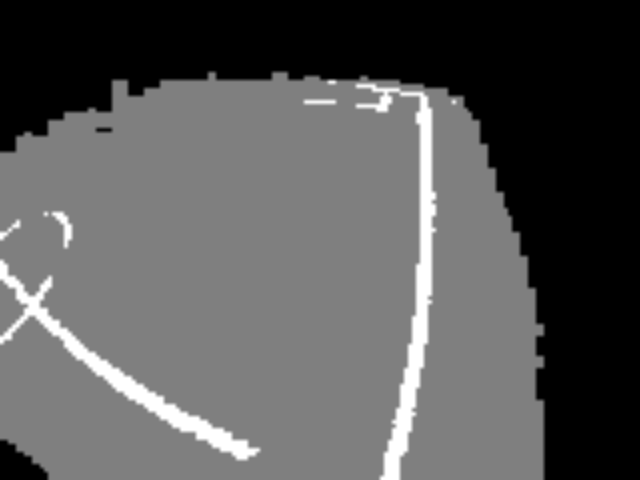

In [39]:
TF.resize(TF.to_pil_image(seg.cpu()[0].argmax(0)/2.0),(480,640))

# Loss Visualisation

In [40]:
import seaborn as sns
from matplotlib import pyplot as plt


In [41]:
mse_val_loss = [loss[0] for loss in val_losses]
var_blob = [loss[1] for loss in val_losses]
nll = [loss[2] for loss in val_losses]
var_seg = [loss[3] for loss in val_losses]

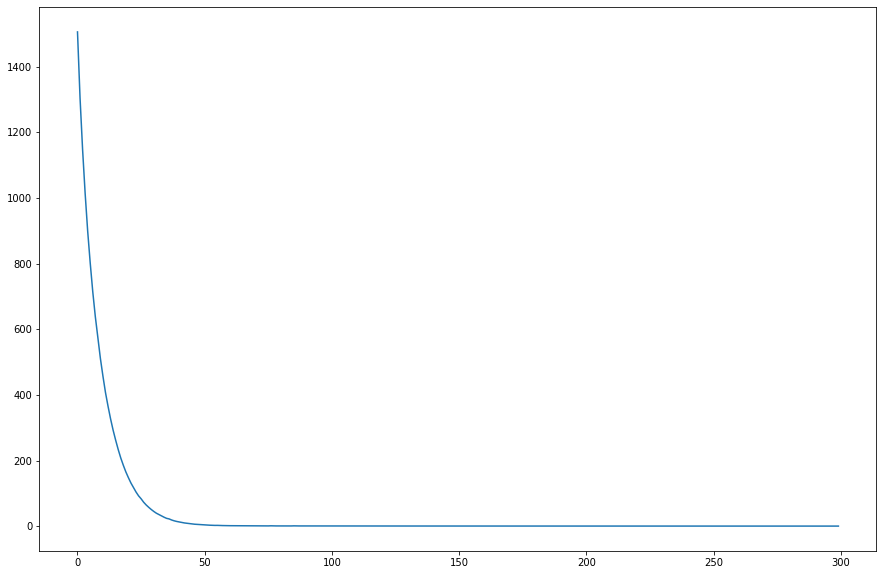

In [73]:
plt.figure(figsize=(15,10))
sns.lineplot(data=np.array(mse_val_loss))
plt.show()

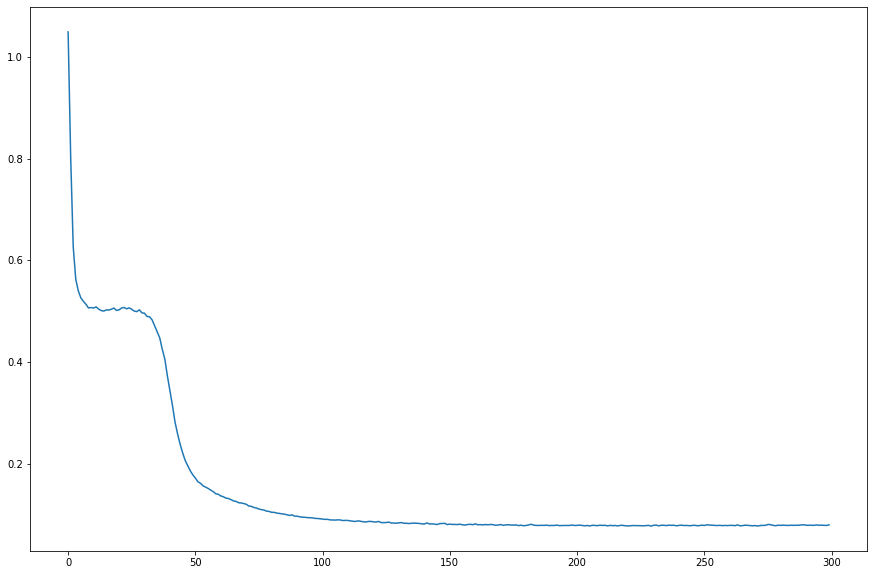

In [43]:
plt.figure(figsize=(15,10))
sns.lineplot(data=np.array(nll))
plt.show()

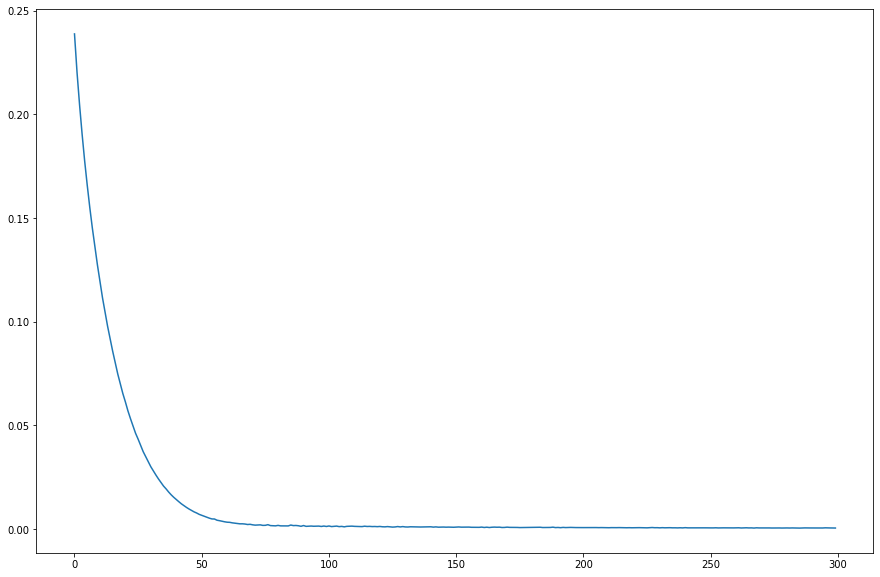

In [74]:
plt.figure(figsize=(15,10))
sns.lineplot(data=np.array(var_blob))
plt.show()

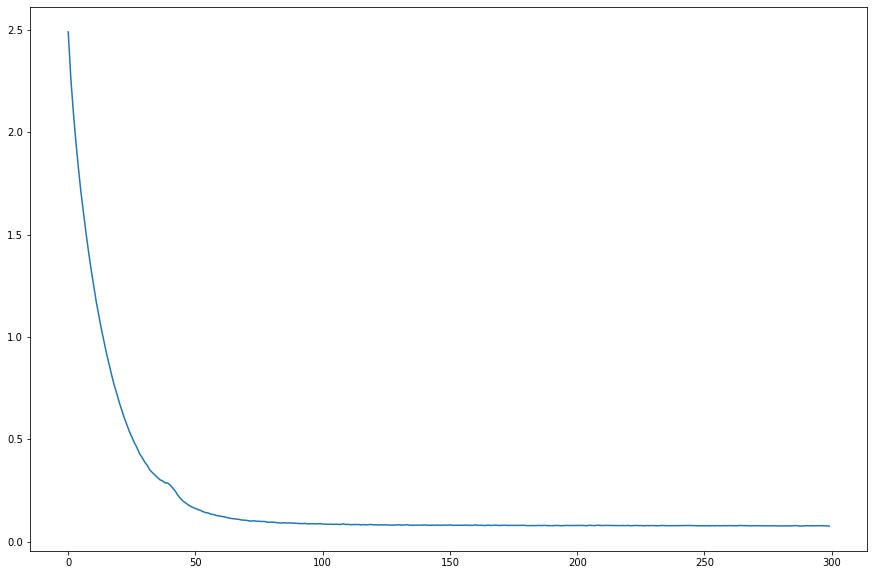

In [45]:
plt.figure(figsize=(15,10))
sns.lineplot(data=np.array(var_seg))
plt.show()

# Accuracy and IoU on Segmentation Head

In [46]:
torch.cuda.empty_cache()
test_seg_loader = torch.utils.data.DataLoader(test_seg_dataset,batch_size=10,shuffle=False)

## Train Metric

In [70]:
get_seg_metric(train_seg_loader)

Background    	Accuracy:0.984,   	IoU:0.975
Field    	Accuracy:0.991,   	IoU:0.977
Line    	Accuracy:0.892,   	IoU:0.829
Average Accuracy 0.956, Average IoU:0.927


## Validation Metric

In [48]:
get_seg_metric(val_seg_loader)

Background    	Accuracy:0.977,   	IoU:0.960
Field    	Accuracy:0.984,   	IoU:0.964
Line    	Accuracy:0.850,   	IoU:0.765
Average Accuracy 0.937, Average IoU:0.896


## Test Metric

In [47]:
get_seg_metric(test_seg_loader)

Background    	Accuracy:0.974,   	IoU:0.959
Field    	Accuracy:0.987,   	IoU:0.968
Line    	Accuracy:0.868,   	IoU:0.782
Average Accuracy 0.943, Average IoU:0.903


# Accuracy, Precision, Recall and other mertrics on Detection Head

## Train Metric

In [66]:
get_metric(loader=train_blob,mode = 'Training')

Ball    	Recall:0.998
		Precision:0.997
		Accuracy: 0.995
		F1 Score:0.997
		FDR:0.003
------------------------------------------
Goal Post    	Recall:0.995
		Precision:0.995
		Accuracy: 0.991
		F1 Score:0.995
		FDR:0.005
------------------------------------------
Robot    	Recall:0.995
		Precision:0.998
		Accuracy: 0.995
		F1 Score:0.997
		FDR:0.002
------------------------------------------
-----------------------------------------



## Validation Metric

In [69]:
get_metric(loader=val_blob)

Ball    	Recall:0.995
		Precision:0.998
		Accuracy: 0.994
		F1 Score:0.996
		FDR:0.002
------------------------------------------
Goal Post    	Recall:0.991
		Precision:0.988
		Accuracy: 0.982
		F1 Score:0.990
		FDR:0.012
------------------------------------------
Robot    	Recall:0.997
		Precision:1.000
		Accuracy: 0.997
		F1 Score:0.998
		FDR:0.000
------------------------------------------
-----------------------------------------



## Test Metric

In [68]:
get_metric(loader=test_blob,mode = 'Testing',save_images=True)

Ball    	Recall:0.996
		Precision:0.996
		Accuracy: 0.994
		F1 Score:0.996
		FDR:0.004
------------------------------------------
Goal Post    	Recall:0.995
		Precision:0.989
		Accuracy: 0.986
		F1 Score:0.992
		FDR:0.011
------------------------------------------
Robot    	Recall:0.994
		Precision:1.000
		Accuracy: 0.996
		F1 Score:0.997
		FDR:0.000
------------------------------------------
-----------------------------------------

